## Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Activaton functions

In [ ]:
class Activation:
    '''
        Activation class:
            this class contail the different activation function.
            for defining the activation functions as object method they should have two mode.


    '''

    def sigmoid(self, z : np.array, t_path : str = 'forward') -> np.array:
        '''
        Sigmoid Activation funciton:

        parameters:
            z : numpy array as input.
            t_path : string input specifying the runnig mode of activation function
                    in forward mode it calculate the output of activation function
                    and in backward mode in return the numerical derivative of the activation
                    funciton.
        out_put:
            s : depending on the "t_path"
            t_path = forward -> s : sigmoid(z)
            t_path = backward -> s : derivative(sigmoid(z))

        '''
        if t_path == 'forward':
            z = np.clip(z, -500, 500)
            s = 1. / (1 + np.exp(-z))
        elif t_path == 'backward':
            s = (1 - z) * z
        return s


    def ReLu(self, z : np.array, slope : float = 1.,  t_path : str = 'forward') -> np.array:
        '''
        ReLu Activation funciton:

        parameters:
            z : numpy array as input.
            slope : this value determine the slope of relu function. Default value is 1.
            t_path : string input specifying the runnig mode of activation function
                    in forward mode it calculate the output of activation function
                    and in backward mode in return the numerical derivative of the activation
                    funciton.
        out_put:
            s : depending on the "t_path"
            t_path = forward -> s : ReLu(z)
            t_path = backward -> s : derivative(ReLu(z))

        '''

        if t_path == 'forward':
            s = np.maximum(0,z)
        elif t_path == 'backward':
            s = (z > 0).astype(float) * slope
        return s

    def LeakyReLu(self, z : np.array, slope : float = 1. ,alpha : float = 0.01, t_path : str = 'forward') -> np.array:
        '''
        LeakyReLu Activation funciton:

        parameters:
            z : numpy array as input.
            slope : this value determine the slope of Leakyrelu function for positvie values. Default value is 1.
            alpha : this value determine the slope of Leakyrelu function for negatvie values. Default value is 1.
            t_path : string input specifying the runnig mode of activation function
                    in forward mode it calculate the output of activation function
                    and in backward mode in return the numerical derivative of the activation
                    funciton.
        out_put:
            s : depending on the "t_path"
            t_path = forward -> s : LeakyReLu(z)
            t_path = backward -> s : derivative(LeakyReLu(z))

        '''
        if t_path == 'forward':
            s = np.where(z > 0, z * slope, alpha * z)
        elif t_path == 'backward':
            s = np.where(z > 0, slope, alpha)
        return s

    def softmax(self, z : np.array, t_path : str = 'forward') -> np.array:

          z_max = np.max(z, axis = 0, keepdims=True)  # Subtract max for numerical stability
          # print(z-z_max, z_max)
          exp_z = np.exp(z - z_max)
          # print(np.sum(exp_z, axis = 0).shape)
          return exp_z / np.sum(exp_z, axis = 0, keepdims=True)


## Loss Functions

In [ ]:
class Loss:
    '''
    Loss funcion class:
    for creating different losses for different taskes.
    this loss functions have two modes.
    forwrd mode : calculate output loss
    backward mode : return derivative of loss function

    '''
    def bceLoss(self, predicted : np.array, actual : np.array, epsilon : float = 1e-15, t_path : str = 'forward'):
        '''
        Binary Cross Entrpy Loss Function
        Two mode loss function


        '''
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        predicted = predicted.reshape(1, -1)
        actual = actual.reshape(1, -1)
        if t_path == 'forward':
            loss = - (actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
            return np.mean(loss)


        if t_path == 'backward':
            m = actual.shape[1]
            return ((predicted - actual)/(predicted*(1 - predicted)))/m

    def cross_entropy_loss(self, predicted: np.array, actual: np.array, class_number, epsilon: float = 1e-15, t_path: str = 'forward'):
        '''
        Multiclass Cross-Entropy Loss Function
        Two-mode (forward or backward) support
        '''
        predicted = np.clip(predicted, epsilon, 1 - epsilon)  # Avoid log(0)

        if t_path == 'forward':
           actual_1 = np.eye(class_number)[actual.flatten()]  # One-hot encode
           actual_1 = actual_1.T
           loss = -np.sum(actual_1 * np.log(predicted), axis=0)  # sum over classes
           return np.mean(loss)  # mean over batch

    def zero_one_loss(self, predicted : np.array, actual : np.array, t_path : str = 'forward'):
        '''
        Zero One Loss Function
        '''
        size = np.squeeze(actual).shape[0]

        if predicted.shape[0] == 1:
          predicted = (predicted >= 0.5).astype(int)
          score = (predicted == actual).sum()/size
        else:
          predicted = np.argmax(predicted, axis=0)
          # actual = np.argmax(actual, axis=0)
          score = (predicted == actual).sum()/size
        return score


## Data Loader Class

In [ ]:
class Dataset:
    '''
    Dataset class for working with datasets:
        this class create batches of data and return batches in step.
        Parameters:
        Data : np.array. Dataset array without target values. size should be (# features, # instances)
        Label : np.array of Labels
        batch_size : int value the number of instances in each batch
        shuffle : boolean variable determine shuffling the data before batching
    '''
    def __init__(self, Data : np.array, Label : np.array, batch_size : int, shuffle : bool = False):

        self.Data : np.array = Data
        self.Label : np.array = Label.reshape(1, -1)
        self.s : int = 0
        self.batch_size : int = batch_size
        self.e : int = self.Data.shape[1] // self.batch_size

        if shuffle:
            indices : np.array = np.arange(self.Data.shape[1])
            np.random.shuffle(indices)
            self.Data : np.array = self.Data[:, indices]
            self.Label : np.array = self.Label[:, indices]

    def data_loader(self) -> (np.array):
        '''
        data_loader method
        every time this method be called as out put it return a batch of data and label
        '''
        if self.s + self.batch_size >= self.Data.shape[1]:
            x : np.array = self.Data[:, self.s:]
            y : np.array = self.Label[:, self.s:]
            self.s : int = 0
        else:
            x : np.array = self.Data[:, self.s : self.s + self.batch_size + 1]
            y : np.array = self.Label[:, self.s : self.s + self.batch_size + 1]

        self.s += self.batch_size
        return x, y


## Optimizer Class

In [ ]:
class Optimizer:
    '''
    Optimize class:
        class contain different optimizer


    '''
    def __init__(self):
        self.m = {}
        self.v = {}
        self.t = 0
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def bgd_optimizer(self, params : dict, derivatives : dict, alpha : float = 0.01) -> dict:
        for layer in range(len(params)):
            params['Layer_'+ str(layer)]['W_' + str(layer)] -= alpha * derivatives['Layer_'+ str(layer)]['dW_' + str(layer)]
            params['Layer_'+ str(layer)]['b_' + str(layer)] -= alpha * derivatives['Layer_'+ str(layer)]['db_' + str(layer)]

        return params

    def adam_optimizer(self, params: dict, derivatives: dict, alpha: float = 0.001) -> dict:
      self.t += 1  # Increment timestep

      for layer in range(len(params)):
          for param_key in ['W', 'b']:
              name = f'{param_key}_{layer}'
              dname = f'd{param_key}_{layer}'
              layer_key = f'Layer_{layer}'

              # Skip if derivative is missing (2-layer NN)
              if layer_key not in derivatives or dname not in derivatives[layer_key]:
                  continue

              # Initialize m and v if not present
              if layer_key not in self.m:
                  self.m[layer_key] = {}
                  self.v[layer_key] = {}

              if name not in self.m[layer_key]:
                  self.m[layer_key][name] = np.zeros_like(params[layer_key][name])
                  self.v[layer_key][name] = np.zeros_like(params[layer_key][name])

              # Update moments
              self.m[layer_key][name] = self.beta1 * self.m[layer_key][name] + (1 - self.beta1) * derivatives[layer_key][dname]
              self.v[layer_key][name] = self.beta2 * self.v[layer_key][name] + (1 - self.beta2) * (derivatives[layer_key][dname] ** 2)

              # Bias correction
              m_hat = self.m[layer_key][name] / (1 - self.beta1 ** self.t)
              v_hat = self.v[layer_key][name] / (1 - self.beta2 ** self.t)

              # Parameter update
              params[layer_key][name] -= alpha * m_hat / (np.sqrt(v_hat) + self.epsilon)

      return params


## Saving and loading Models

In [ ]:
def save_best_model(params, filename):
    """Save best model parameters to a file."""
    filepath = f"/content/{filename}_best_model.npy"  # Ensure the correct path
    np.save(filepath, params) # Save model parameters

def load_best_model(filename):
    """Load best model parameters from a file."""
    filepath = f"/content/{filename}_best_model.npy"
    return np.load(filepath, allow_pickle=True).item()


In [ ]:
def save_error_history(error_history, filename):
    """Save error history to /content/filename."""
    filepath = f"/content/{filename}_error_history.npy"
    np.save(filepath, np.array(error_history))  # Convert list to numpy array before saving
def load_error_history(filename):
    """load error history to /content/filename."""
    filepath = f"/content/{filename}_error_history.npy"
    return np.load(filepath, allow_pickle=True)

## Neural Net class

In [ ]:
class NN:

    '''
    Neural Net Class


    '''
    def __init__(self, file_name, input_shape : int, neuron_list : list[int], loss_fn : Loss ,activaion_f_list : list[str] = None, param_init : list[tuple] = None, name : str = "NN"):

        self.input_shape : int = input_shape # number of features

        self.neuron_list : list[int] = neuron_list # list contain the number of neurons in different layers
        self.parameters : dict = {} # dictionary of the model parameters
        self.derivatives : dict = {} # dictionary of the gradients
        self.forward_path_mem : dict = {} # dictionary of forward path memory
        self.activation_f_list = activaion_f_list # list of activation functions. for each layer have to be one activation function
        self._initia_parameters(param_init) # list of different initilizer of the different layer weights list of string
        self.loss_fn = loss_fn
        self.Layer = len(self.neuron_list) - 1
        self.num_class = self.neuron_list[-1]
        self.model_name = name
        self.file_name = file_name



    def _initia_parameters(self, p : list[tuple]):
        '''
        initialing weights

        '''

        if p == None:
            p = []
            for i in range(len(self.neuron_list)):
                p.append((('normal', 0.01)))

        for layer, arg in enumerate(self.neuron_list):

            if layer == 0:
                self.parameters["Layer_" + str(layer)] = {"W_"+ str(layer) : self._random_init(self.input_shape, arg, p[layer]),
                                                        "b_"+ str(layer) : np.zeros((arg, 1)),}
            else:
                self.parameters["Layer_" + str(layer)] = {"W_"+ str(layer) : self._random_init(self.neuron_list[layer - 1], arg, p[layer]),

                                                        "b_"+ str(layer) : np.zeros((arg, 1)),}



    def _random_init(self, input_s : int, output_s : int, p : tuple) -> np.array:
        if p[0] == 'normal':
            W = np.random.randn(output_s,input_s) * p[1]
        return W



    def train(self, epochs : int, Data_loader_obj, optimizer, x_val = None, y_val = None):
        loss_history = []
        for epoch in range(epochs):

            total_loss = 0
            best_error = np.inf
            size = 0
            for i in range(Data_loader_obj.e):
                X, y = Data_loader_obj.data_loader()

                if X.size == 0:
                    break

                # print(X)
                size += X.shape[1]
                self._forward_path(X)

                predicted = self.forward_path_mem['Layer_' + str(self.Layer)]["A_" + str(self.Layer)]
                loss_value = self.loss_fn(predicted, y, t_path = 'forward')
                total_loss += loss_value

                self._backward_path(X, y)

                self.parameters = optimizer(self.parameters, self.derivatives)

            av_loss = total_loss/size

            if av_loss < best_error:
                best_errpr = av_loss
                best_params = self.parameters.copy()
                save_best_model(best_params, self.file_name)
            loss_history.append(av_loss)

            if (epoch + 1) % 25 == 0:

                print(f"epoch {epoch + 1}/{epochs}")
                print(f"The total loss is {av_loss}")
                print("==========================================\n")


        loss_history = np.array(loss_history)
        # Save error history at the end of training
        save_error_history(loss_history, self.file_name)


    def predict(self, X):
        self._forward_path(X)
        predicted_prob = self.forward_path_mem['Layer_' + str(self.Layer)]["A_" + str(self.Layer)]
        return {'raw' :predicted_prob, 'class' : np.argmax(predicted_prob, axis=0)}



    def _forward_path(self, Data : np.array): # forward path funciton

        A = Data
        for layer in range(len(self.neuron_list)):
            Z = np.dot(self.parameters["Layer_" + str(layer)]["W_"+ str(layer)], A)
            Z = Z + self.parameters["Layer_" + str(layer)]["b_"+ str(layer)]
            A = self.activation_f_list[layer](Z, t_path = 'forward')
            self.forward_path_mem['Layer_' + str(layer)] = {"Z_" + str(layer) : Z, "A_" + str(layer) : A}



    def _backward_path(self, Data, Label): #backward path

        if self.num_class > 2:
            Label_1 = np.eye(self.num_class)[Label]
            Label_1 = np.squeeze(Label_1).T
        else:
            Label_1 = Label

        for layer in range(self.Layer + 1)[::-1]:
            if layer == self.Layer:
                dZ = (self.forward_path_mem['Layer_' + str(layer)]["A_" + str(layer)] - Label_1)/(Data.shape[1])
                dW = np.dot(dZ, (self.forward_path_mem['Layer_' + str(layer - 1)]["A_" + str(layer - 1)]).T)
                db = np.sum(dZ, axis=1, keepdims=True)
                self.derivatives['Layer_'+str(layer)] = {'dW_'+str(layer) : dW, 'db_'+str(layer) : db}


            elif layer == 0:
                dZ = np.dot((self.parameters['Layer_' + str(layer + 1)]['W_'+ str(layer + 1)]).T, dZ) * self.activation_f_list[layer](self.forward_path_mem['Layer_' + str(layer)]["A_" + str(layer)], t_path = 'backward')
                dW = np.dot(dZ, Data.T)
                db = np.sum(dZ, axis=1, keepdims=True)
                self.derivatives['Layer_'+str(layer)] = {'dW_'+str(layer) : dW, 'db_'+str(layer) : db}

            else:

                dZ = np.dot((self.parameters['Layer_' + str(layer + 1)]['W_'+ str(layer + 1)]).T, dZ) * self.activation_f_list[layer](self.forward_path_mem['Layer_' + str(layer)]["A_" + str(layer)], t_path = 'backward')
                dW = np.dot(dZ, (self.forward_path_mem['Layer_' + str(layer - 1)]["A_" + str(layer - 1)]).T)
                db = np.sum(dZ, axis=1, keepdims=True)
                self.derivatives['Layer_'+str(layer)] = {'dW_'+str(layer) : dW, 'db_'+str(layer) : db}


In [ ]:
def plot_loss_curves(loss_lists, names, layer_lists = None, title = "different models"):
    """
    Plots multiple loss curves on the same graph.

    Parameters:
    loss_lists (list of lists): Each inner list contains loss values over epochs.
    names (list of str): Names corresponding to each loss list for the legend.
    """
    if len(loss_lists) != len(names):
      if len(names) == 1:
        names = names * len(loss_lists)
        plt.figure(figsize=(10, 5))
        for loss, name, layer in zip(loss_lists, names,layer_lists):
            plt.plot(range(1, len(loss) + 1), loss, label=layer)

        plt.xlabel("Epochs")
        plt.ylabel("Loss Value")
        plt.title("Loss Curves - Convergence for " + title)
        plt.legend()
        plt.grid(True)
        plt.show()
      else:
        raise ValueError("Number of loss lists and names must be the same")
    else:
      plt.figure(figsize=(10, 5))
      for loss, name in zip(loss_lists, names):
          plt.plot(range(1, len(loss) + 1), loss, label=name)

      plt.xlabel("Epochs")
      plt.ylabel("Loss Value")
      plt.title("Loss Curves - Convergence for " + title)
      plt.legend()
      plt.grid(True)
      plt.show()


In [ ]:
from functools import partial
from sklearn.model_selection import train_test_split
from scipy import io

# IRIS

## Data load

In [ ]:
iris = datasets.load_iris()
data = iris['data']
target = iris['target']
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = np.array(x_train).T, np.array(x_test).T, np.array(y_train), np.array(y_test)


# Print shapes to confirm
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (4, 120)
y_train shape: (120,)
X_test shape: (4, 30)
y_test shape: (30,)


## Model Train

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 3)
act = Activation()
Dataset_obj = Dataset(x_train, y_train, batch_size=12, shuffle=True)
optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

### 3 Layer Different activation

## IRIS TRAIN and TEST ACCURACY

### ReLu

In [ ]:
model_1_ReLu = NN(input_shape=x_train.shape[0], neuron_list=[128, 64, 3], loss_fn=loss_fn, activaion_f_list=[act.ReLu, act.ReLu, act.softmax], file_name = "iris_3layer_ReLu")
model_1_ReLu.train(epochs = 300, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 25/300
The total loss is 0.007690067964410115

epoch 50/300
The total loss is 0.004661624291386957

epoch 75/300
The total loss is 0.004148781767126767

epoch 100/300
The total loss is 0.004027659330988713

epoch 125/300
The total loss is 0.004114382576571305

epoch 150/300
The total loss is 0.003815208146911962

epoch 175/300
The total loss is 0.005367861260656524

epoch 200/300
The total loss is 0.003915214565854897

epoch 225/300
The total loss is 0.004140116091373228

epoch 250/300
The total loss is 0.004735359477214892

epoch 275/300
The total loss is 0.0037674591102687

epoch 300/300
The total loss is 0.003699879273885633



In [ ]:
loss = Loss()
print("IRIS 3 Layer Model ReLu Test Accuracy : ", loss.zero_one_loss(model_1_ReLu.predict(x_test)['raw'], y_test)*100)
print("IRIS 3 Layer Model ReLu Train Accuracy : ", loss.zero_one_loss(model_1_ReLu.predict(x_train)['raw'], y_train)*100)

IRIS 3 Layer Model ReLu Test Accuracy :  100.0
IRIS 3 Layer Model ReLu Train Accuracy :  97.5


### Sigmoid

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 3)
act = Activation()
Dataset_obj = Dataset(x_train, y_train, batch_size=12, shuffle=True)
optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model_1_sigmoid = NN(input_shape=x_train.shape[0], neuron_list=[128, 64, 3], loss_fn=loss_fn, activaion_f_list=[act.sigmoid, act.sigmoid, act.softmax], file_name = "iris_3layer_sigmoid")
model_1_sigmoid.train(epochs = 300, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 25/300
The total loss is 0.034033075281306925

epoch 50/300
The total loss is 0.009050393647947998

epoch 75/300
The total loss is 0.005661787510136426

epoch 100/300
The total loss is 0.006569642631639544

epoch 125/300
The total loss is 0.004710498844727249

epoch 150/300
The total loss is 0.004312000916539857

epoch 175/300
The total loss is 0.00415986768019109

epoch 200/300
The total loss is 0.004139589097785447

epoch 225/300
The total loss is 0.005084517906269325

epoch 250/300
The total loss is 0.004527148489716855

epoch 275/300
The total loss is 0.004013268419442632

epoch 300/300
The total loss is 0.003939378509936378



In [ ]:
loss = Loss()
print("IRIS 3 Layer Model Sigmoid Test Accuracy : ", loss.zero_one_loss(model_1_sigmoid.predict(x_test)['raw'], y_test)*100)
print("IRIS 3 Layer Model Sigmoid Train Accuracy : ", loss.zero_one_loss(model_1_sigmoid.predict(x_train)['raw'], y_train)*100)

IRIS 3 Layer Model Sigmoid Test Accuracy :  100.0
IRIS 3 Layer Model Sigmoid Train Accuracy :  98.33333333333333


### Leaky ReLu

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 3)
act = Activation()
Dataset_obj = Dataset(x_train, y_train, batch_size=12, shuffle=True)
optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model_1_lrelu = NN(input_shape=x_train.shape[0], neuron_list=[128, 64, 3], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.LeakyReLu, act.softmax], file_name = "iris_3layer_LeakyReLu")
model_1_lrelu.train(epochs = 300, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 25/300
The total loss is 0.0055024687245567834

epoch 50/300
The total loss is 0.0043004213660647545

epoch 75/300
The total loss is 0.004274998571109808

epoch 100/300
The total loss is 0.004174259952601573

epoch 125/300
The total loss is 0.004206388261172677

epoch 150/300
The total loss is 0.0038713523245008184

epoch 175/300
The total loss is 0.0038725339881710754

epoch 200/300
The total loss is 0.004514397908556289

epoch 225/300
The total loss is 0.005710099664940205

epoch 250/300
The total loss is 0.003976551076015176

epoch 275/300
The total loss is 0.00366381893855196

epoch 300/300
The total loss is 0.003792691110091524



In [ ]:
loss = Loss()
print("IRIS 3 Layer Model LeakyReLu Test Accuracy : ", loss.zero_one_loss(model_1_lrelu.predict(x_test)['raw'], y_test)*100)
print("IRIS 3 Layer Model LeakyReLu Train Accuracy : ", loss.zero_one_loss(model_1_lrelu.predict(x_train)['raw'], y_train)*100)

IRIS 3 Layer Model LeakyReLu Test Accuracy :  100.0
IRIS 3 Layer Model LeakyReLu Train Accuracy :  97.5


### Plot the error curve

In [ ]:
A_names = ["Sigmoid", "ReLu", "LeakyReLu"]

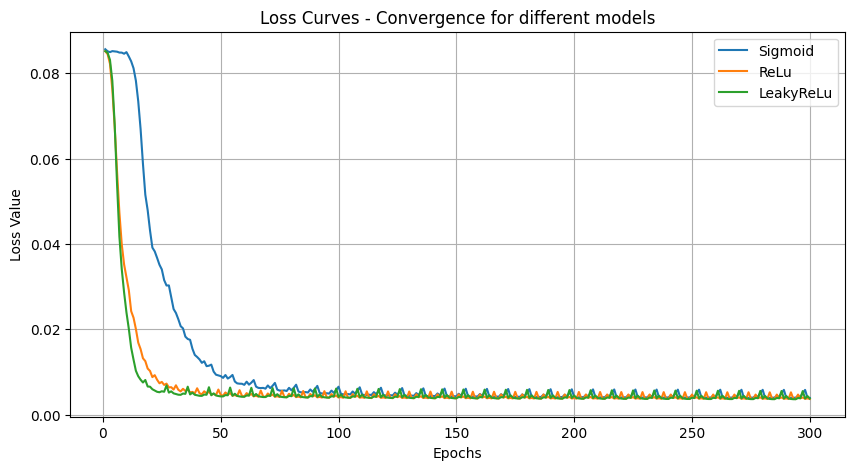

In [ ]:
err_his_3l_iris_sigmoid = load_error_history("iris_3layer_sigmoid")
err_his_3l_iris_ReLu = load_error_history("iris_3layer_ReLu")
err_his_3l_iris_lrelu = load_error_history("iris_3layer_LeakyReLu")
Err_list = [err_his_3l_iris_sigmoid, err_his_3l_iris_ReLu, err_his_3l_iris_lrelu]
plot_loss_curves(Err_list, A_names, 'IRIS')

### Different layers for Leaky ReLu activation

#### 2 layer

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 3)
act = Activation()
Dataset_obj = Dataset(x_train, y_train, batch_size=12, shuffle=True)
optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model_2_lrelu = NN(input_shape=x_train.shape[0], neuron_list=[128, 3], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.softmax], file_name = "iris_2layer_LeakyReLu")
model_2_lrelu.train(epochs = 300, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 25/300
The total loss is 0.010568805669771409

epoch 50/300
The total loss is 0.004626974677379152

epoch 75/300
The total loss is 0.004395687376504937

epoch 100/300
The total loss is 0.0029170410321843776

epoch 125/300
The total loss is 0.0026302555494177008

epoch 150/300
The total loss is 0.002532388503076709

epoch 175/300
The total loss is 0.002376227617881834

epoch 200/300
The total loss is 0.0026819039190095328

epoch 225/300
The total loss is 0.00241582893733708

epoch 250/300
The total loss is 0.002461687085988448

epoch 275/300
The total loss is 0.0022259095902584965

epoch 300/300
The total loss is 0.003226208256085757



In [ ]:
loss = Loss()
print("IRIS 2 Layer Model LeakyReLu Test Accuracy : ", loss.zero_one_loss(model_2_lrelu.predict(x_test)['raw'], y_test)*100)
print("IRIS 2 Layer Model LeakyReLu Train Accuracy : ", loss.zero_one_loss(model_2_lrelu.predict(x_train)['raw'], y_train)*100)

IRIS 2 Layer Model LeakyReLu Test Accuracy :  96.66666666666667
IRIS 2 Layer Model LeakyReLu Train Accuracy :  98.33333333333333


#### 4 layers

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 3)
act = Activation()
Dataset_obj = Dataset(x_train, y_train, batch_size=12, shuffle=True)
optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer

In [ ]:
model_3_lrelu = NN(input_shape=x_train.shape[0], neuron_list=[128, 64, 32, 3], loss_fn=loss_fn, activaion_f_list=[act.LeakyReLu, act.LeakyReLu, act.LeakyReLu, act.softmax], file_name = "iris_4layer_LeakyReLu")
model_3_lrelu.train(epochs = 300, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

epoch 25/300
The total loss is 0.007340231720265463

epoch 50/300
The total loss is 0.005716663490461908

epoch 75/300
The total loss is 0.005277570696610128

epoch 100/300
The total loss is 0.0052993155561296326

epoch 125/300
The total loss is 0.0050511316223769975

epoch 150/300
The total loss is 0.005389923566024177

epoch 175/300
The total loss is 0.006727847890172999

epoch 200/300
The total loss is 0.004812576153797751

epoch 225/300
The total loss is 0.005901868625926138

epoch 250/300
The total loss is 0.004967848478704044

epoch 275/300
The total loss is 0.004903016658106556

epoch 300/300
The total loss is 0.004586506576816757



In [ ]:
loss = Loss()
print("IRIS 4 Layer Model LeakyReLu Test Accuracy : ", loss.zero_one_loss(model_3_lrelu.predict(x_test)['raw'], y_test)*100)
print("IRIS 4 Layer Model LeakyReLu Train Accuracy : ", loss.zero_one_loss(model_3_lrelu.predict(x_train)['raw'], y_train)*100)

IRIS 4 Layer Model LeakyReLu Test Accuracy :  100.0
IRIS 4 Layer Model LeakyReLu Train Accuracy :  97.5


#### plot the error curves

In [ ]:
A_names = ["LeakyReLu"]
L_names = ["2 Layer", "3 Layer", "4 Layer"]

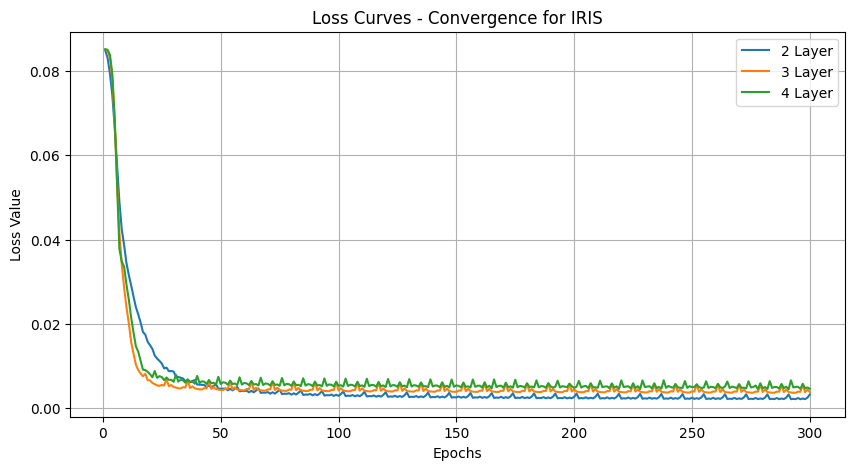

In [ ]:
err_his_2_lrelu = load_error_history("iris_2layer_LeakyReLu")
err_his_3_lrelu = load_error_history("iris_3layer_LeakyReLu")
err_his_4_lrelu = load_error_history("iris_4layer_LeakyReLu")
Err_list = [err_his_2_lrelu, err_his_3_lrelu, err_his_4_lrelu]
plot_loss_curves(Err_list, A_names, L_names, 'IRIS')

# Other Data SETS

# MLL DATA SET

In [ ]:
mat = io.loadmat('/content/MLL_data_label_all.mat')
x_train = np.array(mat['train_data'],dtype = None).T
y_train =np.array( mat['train_label'],dtype =None).reshape(-1)
x_test = np.array(mat['test_data'],dtype =None).T
y_test = np.array(mat['test_label'],dtype =None).reshape(-1)

y_train = y_train - 1
y_test = y_test - 1

In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 3)
act = Activation()

Dataset_obj = Dataset(x_train, y_train, batch_size=5, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer


model_2 = NN(input_shape=x_train.shape[0], neuron_list=[128, 64, 3], loss_fn=loss_fn, activaion_f_list=[act.ReLu, act.ReLu, act.softmax], file_name = "MLL_3layer_ReLu")

model_2.train(epochs = 300, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

## MLL TRAIN TEST ACCURACY

In [ ]:
loss = Loss()
print("MLL 3 Layer Model Test Accuracy : ", loss.zero_one_loss(model_2.predict(x_test)['raw'], y_test)*100)
print("MLL 3 Layer Model Train Accuracy : ", loss.zero_one_loss(model_2.predict(x_train)['raw'], y_train)*100)

## MLL CONVERGENCE CURVE

In [ ]:
MLL_loss_history = load_error_history("MLL_3layer_ReLu")
plot_loss_curves([MLL_loss_history], ['3 Layer Model'], title = ' MLL Training Convergence')

# MADELON DATA SET

In [ ]:
mat = io.loadmat('/content/Madelon_data_label_all.mat')
x_train = np.array(mat['train_data'],dtype = None).T
y_train =np.array( mat['train_label'],dtype =None).reshape(-1)
x_test = np.array(mat['test_data'],dtype =None).T
y_test = np.array(mat['test_label'],dtype =None).reshape(-1)


In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 2)
act = Activation()

Dataset_obj = Dataset(x_train, y_train, batch_size=32, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer


model_3 = NN(input_shape=x_train.shape[0], neuron_list=[128, 64, 1], loss_fn=loss_fn, activaion_f_list=[act.ReLu, act.ReLu, act.sigmoid], file_name = "Madelon_3layer_ReLu")

model_3.train(epochs = 200, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

Madellon ACCURACY

In [ ]:
loss = Loss()
print("MADELON 3 Layer Model Test Accuracy : ", loss.zero_one_loss(model_3.predict(x_test)['raw'], y_test)*100)
print("MADELON 3 Layer Model Train Accuracy : ", loss.zero_one_loss(model_3.predict(x_train)['raw'], y_train)*100)

## MADELLON CONVERGENCE CURVE

In [ ]:
Madelon_loss_history = load_error_history("Madelon_3layer_ReLu")
plot_loss_curves([Madelon_loss_history], ['3 Layer Model'], title = ' Madelon Training Convergence')

# LEUKEMIA DATA SET

In [ ]:
mat = io.loadmat('/content/Leukemia_data_label_all.mat')
x_train = np.array(mat['train_data'],dtype = None).T
y_train =np.array( mat['train_label'],dtype =None).reshape(-1)
x_test = np.array(mat['test_data'],dtype =None).T
y_test = np.array(mat['test_label'],dtype =None).reshape(-1)


In [ ]:
loss = Loss()
loss_fn = partial(loss.cross_entropy_loss, class_number = 2)
act = Activation()

Dataset_obj = Dataset(x_train, y_train, batch_size=5, shuffle=True)

optim = Optimizer()
opt_fn = optim.adam_optimizer #optim.adam_optimizer # or optimizer.bgd_optimizer


model_3 = NN(input_shape=x_train.shape[0], neuron_list=[128, 64, 1], loss_fn=loss_fn, activaion_f_list=[act.ReLu, act.ReLu, act.sigmoid], file_name = "Leukemia_3layer_ReLu")

model_3.train(epochs = 200, Data_loader_obj=Dataset_obj, optimizer= opt_fn)

## TEST TRAIN ACCURACY

In [ ]:
loss = Loss()
print("LEUKEMIA 3 Layer Model Test Accuracy : ", loss.zero_one_loss(model_3.predict(x_test)['raw'], y_test)*100)
print("LEUKEMIS 3 Layer Model Train Accuracy : ", loss.zero_one_loss(model_3.predict(x_train)['raw'], y_train)*100)

## LEUKEMIA CONVERGENCE RATE

In [ ]:
Leukemia_loss_history = load_error_history("Leukemia_3layer_ReLu")
plot_loss_curves([Leukemia_loss_history], ['3 Layer Model'], title = ' Leukemia')